In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
import neo
import elephant as el
import elephant.conversion as conv
import elephant.statistics as stat
from quantities import Hz, s, ms
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [116]:
def raster_plot(spk):
    for i, spiketrain in enumerate(spk):
        t = spiketrain.rescale(ms)
        plt.plot(t,i*np.ones_like(t),'k.',markersize=2)
    plt.axis('tight')
    # plt.xlim(500000,510000)
    plt.xlabel('Time(ms)',fontsize=16)
    plt.ylabel('Spike Train Index',fontsize=16)
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.show()

# special loader function to bring nested structs into Python
# thanks to StackOverflow!
import scipy.io as spio
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def compare_rasters(spk,idx1,idx2):
    spk1=[]
    spk2=[]
    for spiketrain in spk:
        temp1=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[idx1])&(spiketrain.times<exp1stop[idx1])])
        spk1.append(temp1)
        temp2=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[idx2])&(spiketrain.times<exp1stop[idx2])])
        spk2.append(temp2)
    fig=plt.figure(figsize=(15,8))
    ax1=fig.add_subplot(121)
    for i, spiketrain in enumerate(spk1):
        t = spiketrain.rescale(ms)
        ax1.plot(t,i*np.ones_like(t),'k.',markersize=2)
    #plt.axis('tight')
    # plt.xlim(500000,510000)
    ax1.set_xlabel('Time(ms)',fontsize=16)
    ax1.set_ylabel('Spike Train Index',fontsize=16)
    #ax1.gca().tick_params(axis='both', which='major', labelsize=14)
    
    ax2=fig.add_subplot(122)
    for i, spiketrain in enumerate(spk2):
        t = spiketrain.rescale(ms)
        ax2.plot(t,i*np.ones_like(t),'k.',markersize=2)
   # plt.axis('tight')
    # plt.xlim(500000,510000)
    ax2.set_xlabel('Time(ms)',fontsize=16)
    ax2.set_ylabel('Spike Train Index',fontsize=16)
    
    #plt.gca().tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()
    
def plot_trialavg(trialavg,name=None):
    f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(15,8))
    for i in range(trialavg.shape[1]):
        t = trialavg[:,i]
        ax1.plot(i*np.ones_like(t),t,'k.',markersize=2)
    ax1.axis('tight')
    # plt.xlim(500000,510000)
    ax1.set_xlabel('Neuron index',fontsize=16)
    ax1.set_ylabel(name,fontsize=16)
    # ax1.gca().tick_params(axis='both', which='major', labelsize=14)

    for i in range(trialavg.shape[0]):
        t = trialavg[i,:]
        ax2.plot(i*np.ones_like(t),t,'k.',markersize=2)
    ax2.axis('tight')
    # plt.xlim(500000,510000)
    ax2.set_xlabel('Experiment',fontsize=16)
    # plt.ylabel('CV2',fontsize=16)
    # ax2.gca().tick_params(axis='both', which='major', labelsize=14)

    plt.show()

In [5]:
Fs = 30000.

clu_f = np.load('./frontal/spike_clusters.npy')

ss_f = np.load('./frontal/spike_times.npy')

st_f = ss_f/Fs

spkTemps_f = np.load('./frontal/spike_templates.npy')

amps_f = np.load('./frontal/amplitudes.npy')

amps_f

array([[18.51144409],
       [12.93832397],
       [47.23517227],
       ...,
       [23.7265625 ],
       [31.41118622],
       [18.56385803]])

In [6]:
cid_g_f = pd.read_csv('./frontal/cluster_groups.csv',sep='\t')

noise=cid_g_f[cid_g_f['group']=='noise']

clu_f=pd.DataFrame(clu_f)
clu_f.columns = ['clusters']
st_f_clean=st_f[~clu_f.isin(noise['cluster_id'].tolist())]

st_f_clean=pd.DataFrame(st_f_clean)
st_f_clean.columns = ['spike times']

noise_clu=~clu_f.isin(noise['cluster_id'].tolist())
clu_f_clean=clu_f[noise_clu]
clu_f_clean=pd.DataFrame(clu_f_clean)
clu_f_clean.columns = ['clusters']
clu_f_clean.dropna(inplace=True)
#clu_f_clean.isnull().sum()

clu_f_clean.reset_index(drop=True,inplace=True)

df = clu_f_clean
df['spike times']=st_f_clean

df['clusters'].unique().shape

(822,)

In [7]:
cgs=df['clusters'].unique()

spk=[]
for unit in cgs:
    train=df['spike times'][df.clusters==unit].values
    spk.append(train)

temp=[]
for unit in spk:
    train = neo.SpikeTrain(times=unit,units='sec',t_start=0.0,t_stop=5050.0)
    temp.append(train)
    
spk=temp

Quick example of a raster plot

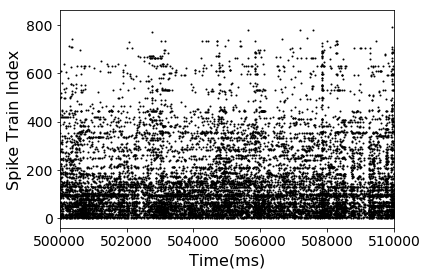

In [8]:
for i, spiketrain in enumerate(spk):
    t = spiketrain.rescale(ms)
    plt.plot(t,i*np.ones_like(t),'k.',markersize=2)
plt.axis('tight')
plt.xlim(500000,510000)
plt.xlabel('Time(ms)',fontsize=16)
plt.ylabel('Spike Train Index',fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()

Now let's look at mean activity across time (averaging across neurons)

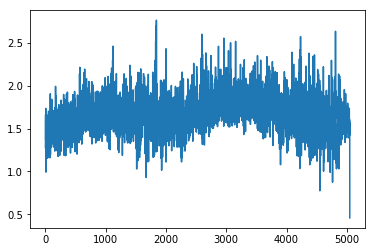

In [9]:
binsize=1*s
spk_binned = conv.BinnedSpikeTrain(spk,binsize=binsize,t_start=0*s).to_array()

mean_spikes = np.mean(spk_binned,0)

plt.plot(mean_spikes)

Now let's look at the histogram of number of spikes per neuron

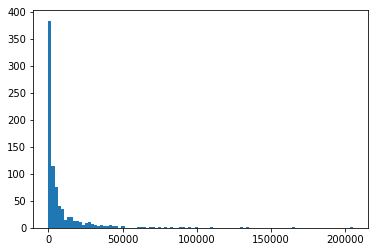

In [10]:
total_spk = np.sum(spk_binned,-1)
# total_spk.shape

_=plt.hist(total_spk,bins=100)

Now let's look at the activity of a single neuron

In [11]:
neuron_ix = 200
neuron = spk_binned[neuron_ix]

unique,counts=np.unique(neuron,return_counts=True)

In [14]:
print(unique)
print(counts)

[0 1 2 3 5]
[3715 1101  204   29    1]


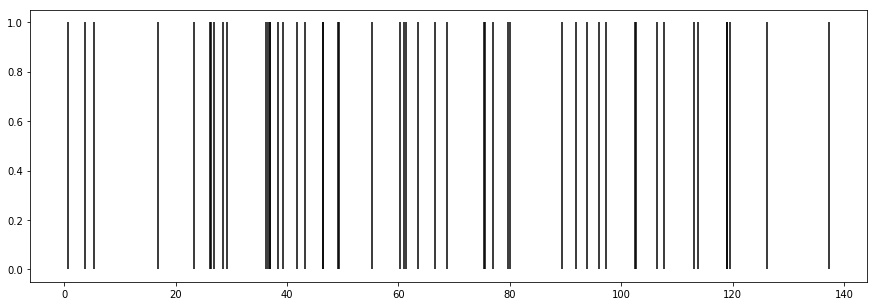

In [15]:
fig,ax=plt.subplots(figsize=(15,5))
ax.vlines(spk[neuron_ix][:50],0,1)

Let's load the experimental protocols into Python

In [16]:
exp1_info=loadmat('experiment1stimInfo.mat')

exp1_info.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Protocol', 'stimStarts', 'stimStops', 'stimIDs'])

In [17]:
exp2_info=loadmat('experiment2stimInfo.mat')

exp3_info=loadmat('experiment3stimInfo.mat')

Now let's divide up the spike trains into the 4 different experimental stages, and then further into a window for each stimulus

In [18]:
N=exp1_info['Protocol']['npfilestimuli']*exp1_info['Protocol']['nrepeats']
exp1start=exp1_info['stimStarts']
exp1stop=exp1_info['stimStops']

In [19]:
## This should only be run when making a new dissimilarity file
# dist_list=[]
# import elephant.spike_train_dissimilarity as dissim

# for i in range(N):
#     print i
#     temp_spks=[]
#     for spiketrain in spk:
#         temp=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[i])&(spiketrain.times<exp1stop[i])])
#         temp_spks.append(temp)
#     dist_list.append(dissim.van_rossum_dist(temp_spks,sort=False))

# with open('spkdist1_VR_f.pkl','wb') as output:
    # pickle.dump(dist_list,output,pickle.HIGHEST_PROTOCOL)

Here we can compare any two stimuli responses - in particular, we want to compare responses among the same stimuli. Should look further into measures of 

In [20]:
np.where(exp1_info['stimIDs']==6)[0]

array([  0,  20,  26,  40,  56,  75,  83, 100, 114, 117])

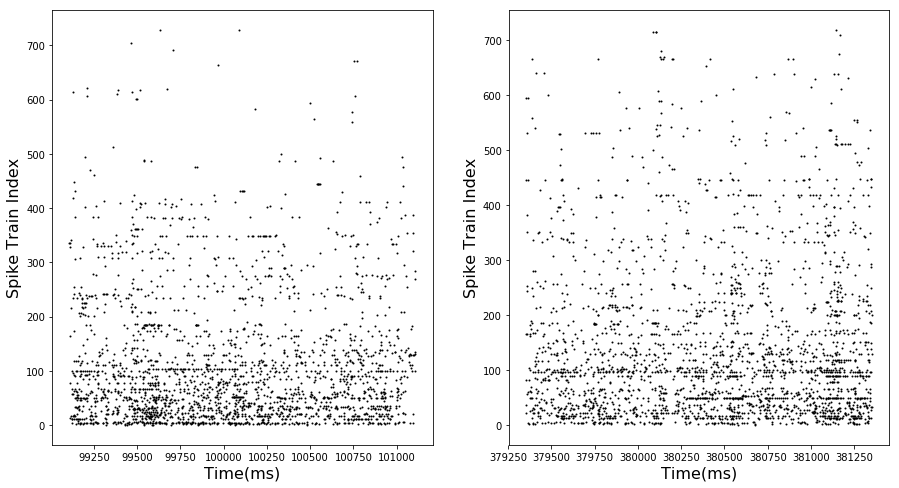

In [21]:
# functionality only for experiment 1 currently!
compare_rasters(spk,0,100)

In [22]:
# with open('spkdist1_VR_f.pkl','rb') as input:
#     dist_list=pickle.load(input)

# from scipy.cluster import hierarchy
# a=dist_list[0]
# z=hierarchy.linkage(a[np.tril_indices(a.shape[0],k=-1)],'average')

# plt.figure(figsize=(15,10))
# dn = hierarchy.dendrogram(z)
    

In [23]:
# from scipy.cluster import hierarchy
# a=dist_list[1]
# z=hierarchy.linkage(a[np.tril_indices(a.shape[0],k=-1)],'average')

# plt.figure(figsize=(18,10))
# dn = hierarchy.dendrogram(z)

In [24]:
spk_binned = conv.BinnedSpikeTrain(spk,binsize=1*ms,t_start=0*s).to_sparse_bool_array()


In [25]:
spk_binned

<822x5050000 sparse matrix of type '<class 'numpy.bool_'>'
	with 6932702 stored elements in Compressed Sparse Row format>

In [26]:
frame=1
ix1=int(np.floor(exp1start[frame]*1000))
ix2=int(np.ceil(exp1stop[frame]*1000))

In [27]:
spk_binned[:,ix1:ix2]

<822x2001 sparse matrix of type '<class 'numpy.bool_'>'
	with 2616 stored elements in Compressed Sparse Row format>

#### Finding features in frames

Here, I will be starting to find features in each of these frames and subjecting them to various ML algorithms to see if any of them have any predictive power.
These initial features may include (list to be expanded):
* binned spike times
* interspike statistics
* spike counts
* spike rates over different windows
* ~~spike concurrencies~~ (maybe later though)
* rate concurrencies

Maybe we'll just start there.

Neural population statistics:  
* $CV_{2}$
* Fano factor
* PSTH
* covariation of rate and regularity
* Dissimilarity (or precision) between spike trains
* self-correlation between ISI
* choice probability measure
* response latencies
* PCA for decomposing into response modes
* temporal dynamics of trial-to-trial variance
* noise correlations (temporally; use GLMs)
* spike count noise correlations 
* fitting GLMs and searching for temporal structure
* 

Ising model accounts for pairwise correlations with the least model-related assumptions

In [78]:
# def find_frame(dataframe,framenum=1):
#     ix1=int(np.floor(exp1start[framenum]*1000))
#     ix2=int(np.ceil(exp1stop[framenum]*1000))
#     df=dataframe[:,ix1:ix2]
#     return df

# def bin_frame(dataframe,framenum=1):
#     ix1=int(np.floor(exp1start[framenum]*1000))
#     ix2=int(np.ceil(exp1stop[framenum]*1000))
#     df=conv.BinnedSpikeTrain(spk,binsize=1*ms,t_start=ix1*ms,t_stop=ix2*ms).to_bool_array()
#     return df

# def add_inst_rate(dataframe_spk,dataframe,framenum=1):
#     ix1=int(np.floor(exp1start[framenum]*1000))
#     ix2=int(np.ceil(exp1stop[framenum]*1000))
#     ratedf=stat.instantaneous_rate(dataframe_spk,1*ms,t_start=ix1*ms,t_stop=ix2*ms)
#     array=np.empty((822,ix2-ix1))
#     for i,rate in enumerate(ratedf):
#         array[i,:]=ratedf[i].as_array()
       


#### For starters, let's look at CV2, LV and the mean firing rate for each stimulus in experiment 1

In [60]:
spk_divvy=[]
for i, start in enumerate(exp1start):
    # print(start)
    start=start*s
    stop=exp1stop[i]*s
    exp_list=[]
    for j, train in enumerate(spk):
        exp_list.append(neo.SpikeTrain(train.times[(train.times>=start)&(train.times<=stop)],t_start=start \
                                      , t_stop=stop))
    spk_divvy.append(exp_list)

In [70]:
isi_array=[]
cv2_array=[]
lv_array=[]
mean_rate_array=[]
for i,trains in enumerate(spk_divvy):
#     print(i)
    isi_list=[]
    cv2_list=[]
    lv_list=[]
    mean_rate_list=[]
    for train in trains:
        isi=stat.isi(train)
        isi_list.append(isi)
        if len(isi)>1:
            lv_list.append(stat.lv(isi))
            cv2_list.append(stat.cv2(isi))
        else:
            lv_list.append(0)
            cv2_list.append(0)
        mean_rate_list.append(stat.mean_firing_rate(train))
    isi_array.append(isi_list)
    cv2_array.append(cv2_list)
    lv_array.append(lv_list)
    mean_rate_array.append(mean_rate_list)
    

In [93]:
seqnums=exp1_info['Protocol']['seqnums']
trialavg_cv2=[]
trialavg_lv=[]
trialavg_meanrate=[]
for seq in seqnums:
    trialavg_cv2.append(np.mean(np.array(cv2_array)[[x-1 for x in seq]],axis=0))
    trialavg_lv.append(np.mean(np.array(lv_array)[[x-1 for x in seq]],axis=0))
    trialavg_meanrate.append(np.mean(np.array(mean_rate_array)[[x-1 for x in seq]],axis=0))

In [96]:
trialavg_cv2=np.array(trialavg_cv2)
trialavg_lv=np.array(trialavg_lv)
trialavg_meanrate=np.array(trialavg_meanrate)

### EDA
Finally we have a little more EDA! These are plots of the $CV_{2}$, LV (local variation) and mean firing rate. On their own they don't seem to mean a whole lot, especially because they are simply highly aggregated measures. However, we can pick up on a few things: first, there seems to be a rather larger cluster close to 1 on CV2 and LV. A value of 1 here indicates a Poisson neuron. Thus many of the neurons close to the surface seem to be closer to Poisson firing. However, as we go deeper, we see a lot of that mass shift downwards, indicating less and less variation in ISI. This is likely an experimental artefact, because not as many spikes are recorded at deeper levels. This hypothesis seems to be verified by the neuron right after index 600, with the higher firing rate and CV2: this neuron seems to have higher fidelity in recording, and thus higher rate and also CV2. It's interesting that this would lead to lower values of CV2 though. 

We can also see some interesting outliers in firing rate close to the surface, and the classic 'very long tails' in firing rate. I'll verify the type of distribution (log-normal, gamma or exponential) next time.

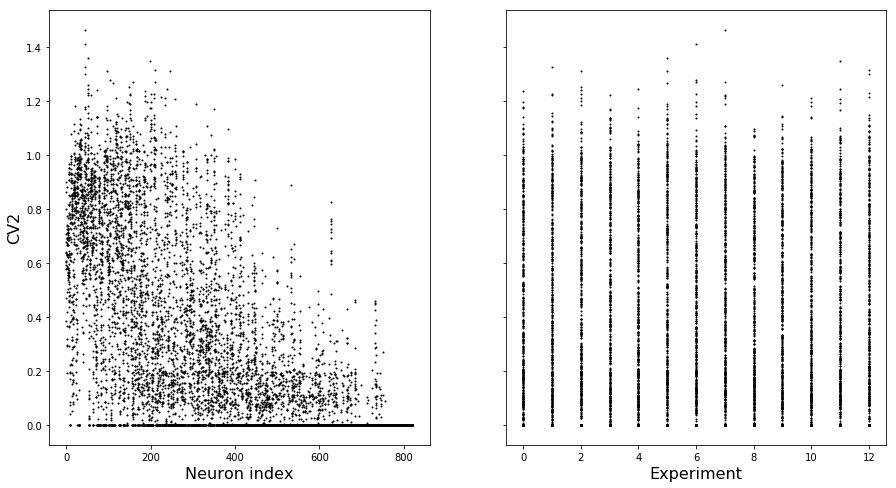

In [117]:
plot_trialavg(trialavg_cv2,name='CV2')

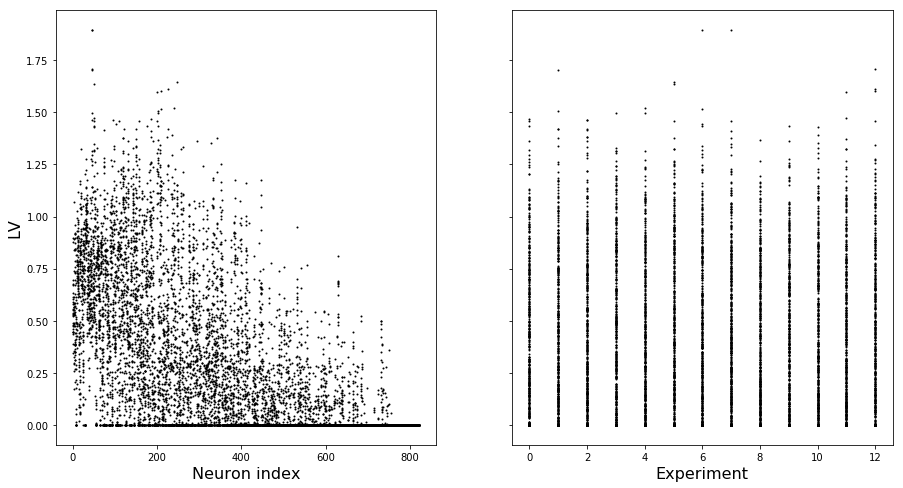

In [118]:
plot_trialavg(trialavg_lv,name='LV')

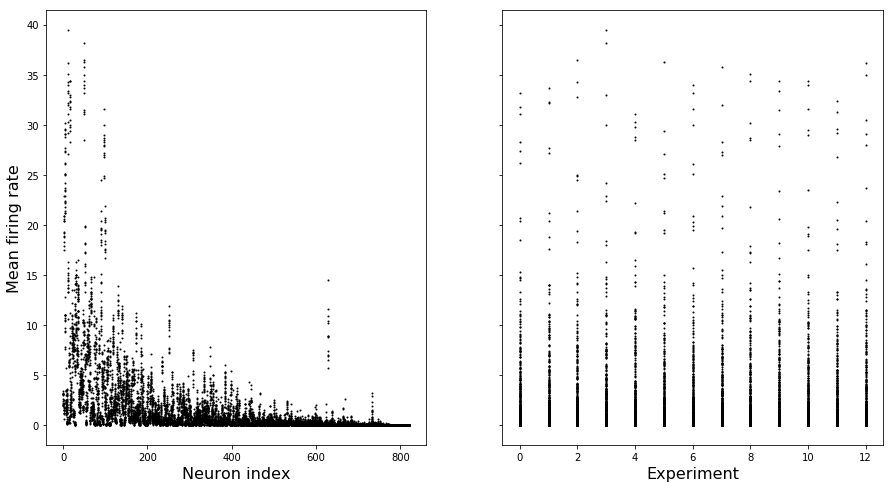

In [119]:
plot_trialavg(trialavg_meanrate,name='Mean firing rate')

In [ ]:
def plot_exp_meancov(trialavg,name=None):
    f,ax2=plt.subplots(1,1,figsize=(10,8))

    for i in range(trialavg.shape[0]):
        t = trialavg[i,:]
        ax2.boxplot(i*np.ones_like(t),t,'k.',markersize=2)
    ax2.axis('tight')
    # plt.xlim(500000,510000)
    ax2.set_xlabel('Experiment',fontsize=16)
    # plt.ylabel('CV2',fontsize=16)
    # ax2.gca().tick_params(axis='both', which='major', labelsize=14)

    plt.show()

Next, I'll be using the [Pillow paper from 2008](http://pillowlab.princeton.edu/pubs/abs_Pillow08_nature.html) to fit GLMs to this spike train data that not only take the stimulus into account, but also the spike-train history and the coupling of other neurons. There's some great [slides](http://pillowlab.princeton.edu/pubs/pillow_TutorialSlides_Cosyne2018.pdf) at the Pillow website that do a good job of really breaking down what's happening in this sort of modeling. It's pretty straightforward if you have any kind of background in stats (and a little state-space modeling). This will be the actually exciting stuff! (I hope).